In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernel_config{configIdx}.pkl', 'rb') as f:
    mdpPolicy = pickle.load(f)
# ==== Prepare Simulator====
num_windows = 10000
obvMode = "perfect" # "perfect" or "predicted"
policySimulator = PolicySimulator(mdpPolicy, env)
simResult = policySimulator.runSimulation(mdpPolicy, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (simResult['uRecord'], simResult['actionsRecord'], 
                                                       simResult['rewardRecord'], simResult['uNextRecord'])


In [6]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.01,
    'lr': 3e-3,
    'eta': 1e-6,
    'dropout_p': 0.1,
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    epochs=500, 
    batch_size=512)

Epoch   50/ 500  Avg Ld=0.1044  Avg Lq=-0.0000  Avg loss_critic=0.1160


Epoch  100/ 500  Avg Ld=0.0462  Avg Lq=-0.0000  Avg loss_critic=0.0015


Epoch  150/ 500  Avg Ld=0.0360  Avg Lq=-0.0000  Avg loss_critic=0.0008


Epoch  200/ 500  Avg Ld=0.0313  Avg Lq=-0.0000  Avg loss_critic=0.0004


Epoch  250/ 500  Avg Ld=0.0251  Avg Lq=-0.0000  Avg loss_critic=0.0003


Epoch  300/ 500  Avg Ld=0.0246  Avg Lq=-0.0000  Avg loss_critic=0.0002


Epoch  350/ 500  Avg Ld=0.0216  Avg Lq=-0.0000  Avg loss_critic=0.0002


Epoch  400/ 500  Avg Ld=0.0200  Avg Lq=0.0000  Avg loss_critic=0.0001


Epoch  450/ 500  Avg Ld=0.0189  Avg Lq=0.0000  Avg loss_critic=0.0001


Epoch  500/ 500  Avg Ld=0.0185  Avg Lq=0.0000  Avg loss_critic=0.0001


In [5]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth


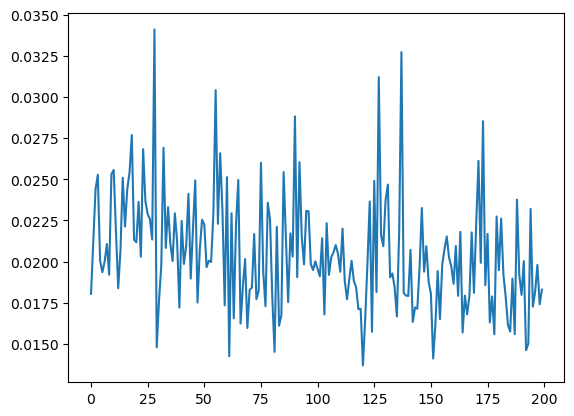

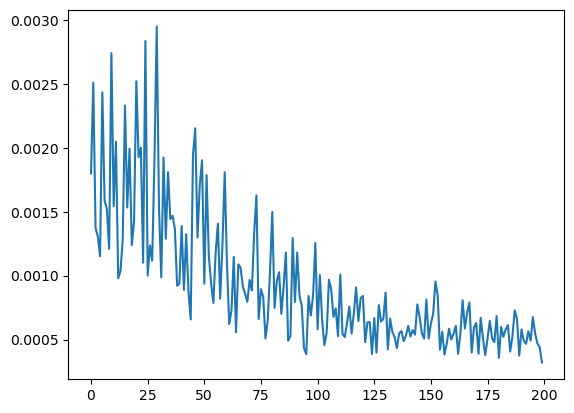

In [7]:
LdRecord = [Ld for Ld in info['LdRecord']]
LqRecord = [Lq for Lq in info['LqRecord']]
lossCriticRecord = [loss_critic for loss_critic in info['lossCriticRecord']]

plt.plot(LdRecord[-200:])
plt.show()
plt.plot(lossCriticRecord[-200:])
plt.show()